In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Add the project directory to sys.path
project_dir = Path.cwd().parent  # Adjust as needed to point to your project root
sys.path.append(str(project_dir))

print("project_dir: ", project_dir)
from utils.pipeline_fixed import Pipeline, EvaluationEnum

dataloader = Pipeline(evaluation=EvaluationEnum.LAST)

file_tag = "economic"
eval_metric = "accuracy"

trnX, tstX, trnY, tstY, target, labels = dataloader.get_economical_classification_train_test()

project_dir:  /Users/jesseoomen/Documents/jaar_3/kdd-process/src


Train#=5656 Test#=735
Labels=[0 1]
RF best for 500 trees (d=7 and f=0.1)


<Figure size 640x480 with 0 Axes>

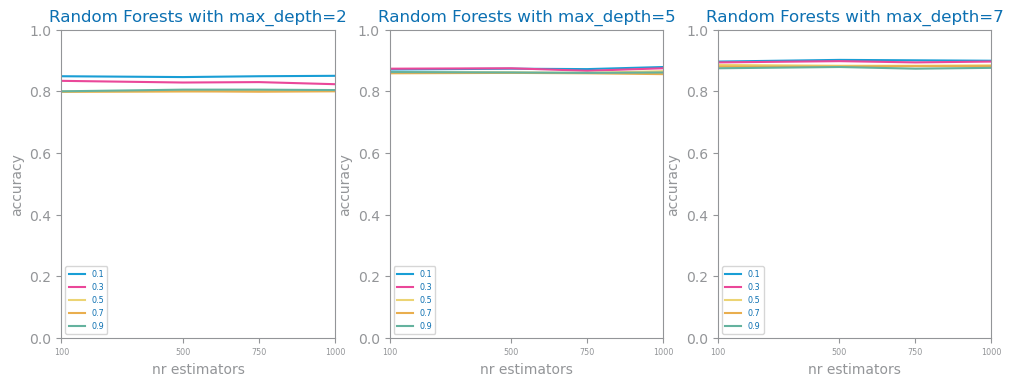

In [2]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from utils.dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from utils.dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params


print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_study.png")
show()

<Figure size 640x480 with 0 Axes>

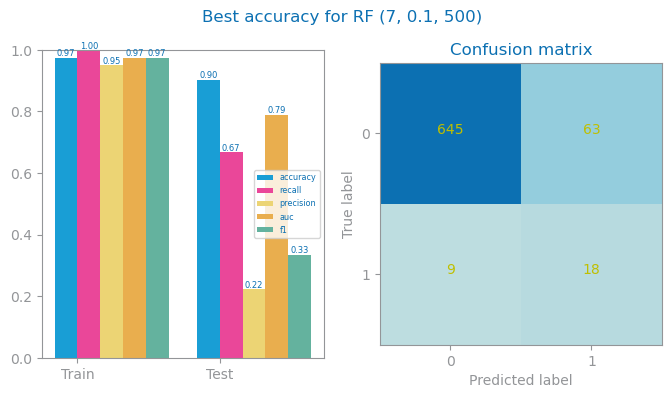

In [3]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
show()

1. x12 (0.18976075016325517)
2. x47 (0.10028941092792203)
3. x42 (0.09335076709049159)
4. x55 (0.06911547834568213)
5. x37 (0.06710323488212842)
6. x60 (0.05411769798121936)
7. x20 (0.03333248534469446)
8. x58 (0.02631174464193627)
9. x39 (0.026221161596339564)
10. x29 (0.021170959868663613)
11. x6 (0.020125365673501372)
12. x21 (0.019920091466620826)
13. x54 (0.019289237699582126)
14. x80 (0.018561801636081458)
15. x45 (0.016590288365972893)
16. x66 (0.016432605457136915)
17. x51 (0.015220245553460066)
18. x74 (0.012772774934489054)
19. x11 (0.012631639088342726)
20. x83 (0.012097016360356818)
21. x28 (0.011459231296379376)
22. x15 (0.011389310394563508)
23. x26 (0.011267198510650852)
24. x65 (0.011116529609311348)
25. x56 (0.009431299230785737)
26. x67 (0.009408198627088237)
27. x27 (0.009300065693685218)
28. x82 (0.00911275388216023)
29. x72 (0.008670237994509737)
30. x22 (0.008346516334444387)
31. x31 (0.008298925789952913)
32. Company (0.008146164847456096)
33. x4 (0.0073953396095

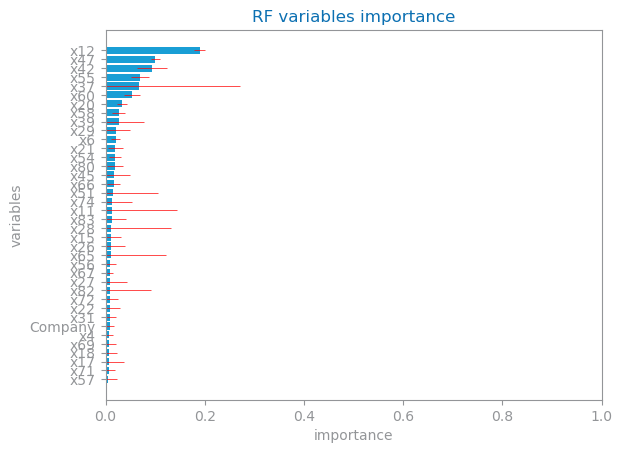

In [4]:
from numpy import std, argsort
from utils.dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
feature_names = trnX.columns  

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []

for f in range(len(feature_names)):
    feature_f = feature_names[indices[f]]
    feature_imp = importances[indices[f]]

    elems.append(feature_f)
    imp_values.append(feature_imp)
    print(f"{f+1}. {feature_f} ({feature_imp})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png")

# Overfitting

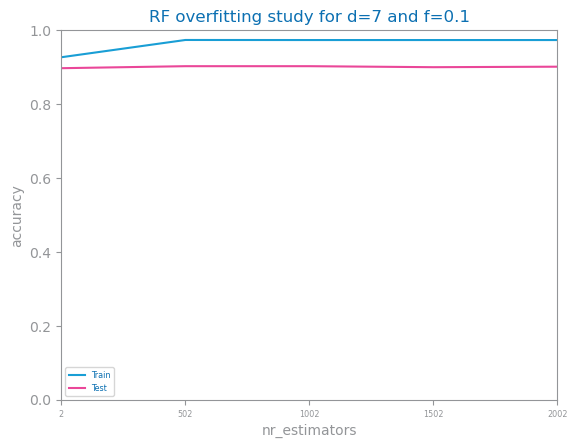

In [5]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")